# PHYS 512 Fall term 2023: FINAL EXAM

## Problem 1

### a)

In [240]:
import numpy as np
import matplotlib.pyplot as plt

def deriv(func, x, h):
    j = complex(0,1)
    return np.imag(func(x+j*h))/h

Let's check our function with $\sin{(x)}$ at $x=1$ and $h = 10^{-4}$. We will see how our approximation and the real results closely match.

In [241]:
dfdx = deriv(np.sin, 1, 1e-4)
print('Numerical approximation =', dfdx)

print('Analytic solution = ', np.cos(1))

Numerical approximation = 0.5403023067686435
Analytic solution =  0.5403023058681398


### b)


In [242]:
# First define the fuction we want to derive
def powof3(x):
    return np.sin(x)**3

# Then we define the centered finite differences method
def centered_finite_differences(func, x, h):
    return (func(x+h)-func(x-h))/(2*h)

We will make use of the centered finite differences to compare 
$$\frac{df}{dx} \approx \frac{f(x+h)-f(x-h)}{2h}$$

In [243]:
# We calculate the analytic result to check the errors
analyt = 3*(np.sin(1.5)**2)*np.cos(1.5)
print('Analytic result = ', analyt)

Analytic result =  0.21114975082386195


For the Centered Finite Differences method, we approximate the derivative as:

$$\frac{df}{dx}\approx \frac{f(x+h)-f(x-h)}{2h}-\frac{h^2}{6}\frac{d^3f}{dx^3}$$.

Resulting in an error that scales as $\propto h^2$.

In the Complex Step Approximation, derived from Taylor expansion, we have: 

$$f(x+ih) \approx f(x)+\left. ih\frac{df}{dx} \right|_{x}- \frac{h^2}{2} \frac{df^2}{d^2x} + O(h^3),$$

Taking the imaginary part yields:

$$\frac{df}{dx}\approx \frac{Im[f(x+ih)]}{h}$$

With an error that also scales as $\propto h^2$. This behavior is depicted in the plot below, where both approximations exhibit decreasing errors proportional to $h^2$ until the Roundoff error becomes significant.

To explain the difference in behavior at lower limits, let's examine the total error for Centered Finite Differences. The total error can be approximated as:

Total error $\approx \frac{\epsilon f(x)}{h} + \frac{h^2}{2}f'''$

The first term accounts for the roundoff error, typically of size $\epsilon$. The second term is the neglected component in the Taylor expansion used for the centered first-order difference.

In contrast, the complex step error steadily decreases until it reaches the order of $\epsilon$ for $h \approx \epsilon^{1/2}$. Unlike regular finite differences, the complex step approximation doesn't encounter a loss of significant digits at the scale of the roundoff error, being explained with the absence of numerical cancellation in floating-point arithmetic.

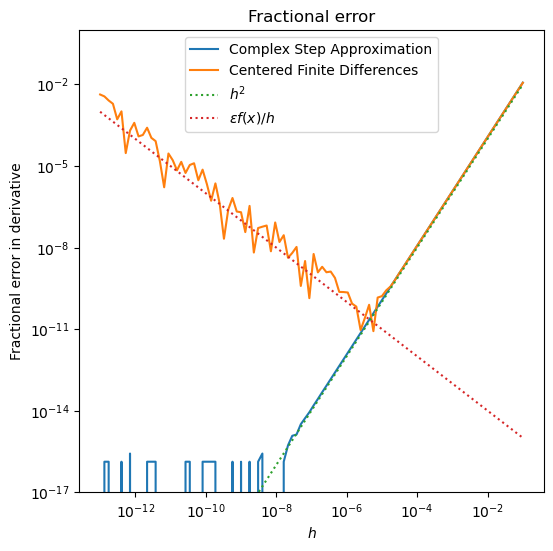

In [244]:
h = 10**np.linspace(-13, -1, 100)

plt.figure(figsize=((6,6)))
plt.title('Fractional error')
plt.plot(h, abs(deriv(powof3, 1.5, h)-analyt)/analyt, label = 'Complex Step Approximation')
plt.plot(h, abs(centered_finite_differences(powof3, 1.5, h)-analyt)/analyt, label = 'Centered Finite Differences')
plt.plot(h, h**2, ":", label=r'$h^2$')
plt.plot(h, 1e-16 * powof3(1.5) / h, ":", label=r'$\epsilon f(x)/h$')
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$h$')
plt.ylabel('Fractional error in derivative')
plt.ylim([10**(-17),1])
plt.legend()
plt.show()


## Problem 2

We acknowledge that $\Psi$ should approach zero in an infinite context. However, to address this, we confine the system within a box where the function is null at the boundaries. By enlarging this box sufficiently, we aim to achieve a progressively more accurate solution. Hence, we enforce the boundary conditions: $\psi(-L) = \psi(L) = 0$.

For simplicity, we use $\hbar = 1$. Attaining actual values at the end merely requires setting the real value of the reduced Planck constant initially or incorporating it afterward to ensure proper unit consistency.

The Schrödinger equation is written as:

$$-\frac{1}{2}\frac{d^2\Psi}{dx^2}+mV(x)\Psi = mE\Psi$$

Transforming this equation into a discrete form using second-order finite differences yields:

$$-\frac{1}{2}\frac{\Psi_{i+1}-2\Psi_i+\Psi_{i-1}}{(\Delta x)^2}+mV_i\Psi_i = mE\Psi_i$$

Resulting in a large system of linear equations for each spatial interval:

$$-\frac{1}{2 (\Delta x)^2}\Psi_{i+1} + \left(\frac{1}{(\Delta x)^2}+mV_i\right)\Psi_i- \frac{1}{2(\Delta x)^2}\Psi_{i-1} = mE\Psi_i$$

We express this as a tridiagonal matrix, considering the boundary conditions:

$$
\begin{pmatrix}
\frac{1}{(\Delta x)^2}+mV_1 & -\frac{1}{2(\Delta x)^2} & 0 & 0\ldots \\
-\frac{1}{2(\Delta x)^2} & \frac{1}{(\Delta x)^2}+mV_2 & -\frac{1}{2(\Delta x)^2} & 0 \ldots \\
\ldots & \ldots & \ldots & \ldots \\
0 & 0 & -\frac{1}{2(\Delta x)^2} & \frac{1}{(\Delta x)^2}+mV_{N-1}\\
\end{pmatrix} 
\begin{pmatrix}
\Psi_1 \\
\Psi_2 \\
\ldots \\
\Psi_{N-1}
\end{pmatrix} = mE\begin{pmatrix}
\Psi_1 \\
\Psi_2 \\
\ldots \\
\Psi_{N-1}
\end{pmatrix}$$

To ensure a tridiagonal matrix, we omit the boundary conditions, resulting in an $(N-2) \times (N-2)$ matrix.

In [245]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh_tridiagonal

# Define parameters
N = 1000  # Number of grid points
L = 50    # Length of the box
dx = 2 * L / N  # Spatial step size
x = np.linspace(-L, L, N + 1)  # Spatial grid

# Constants
# hbar = 1.054571817*(10**-34)
hbar = 1
m = 1 # For simplicity we will set this as 1 (easier to change later if we would like)

# Define the potential function V(x)
def V(x):
    return -np.exp(-np.sqrt(abs(x)))  

# Compute diagonal and off-diagonal elements of the Hamiltonian matrix
d = (hbar**2) / (dx**2) + m * V(x)[1:-1]  # Diagonal elements
e = -(hbar**2) / (2 * (dx**2)) * np.ones(len(d) - 1)  # Off-diagonal elements

# Use eigh_tridiagonal function from scipy to solve the eigenvalue problem
mE, psi = eigh_tridiagonal(d, e)

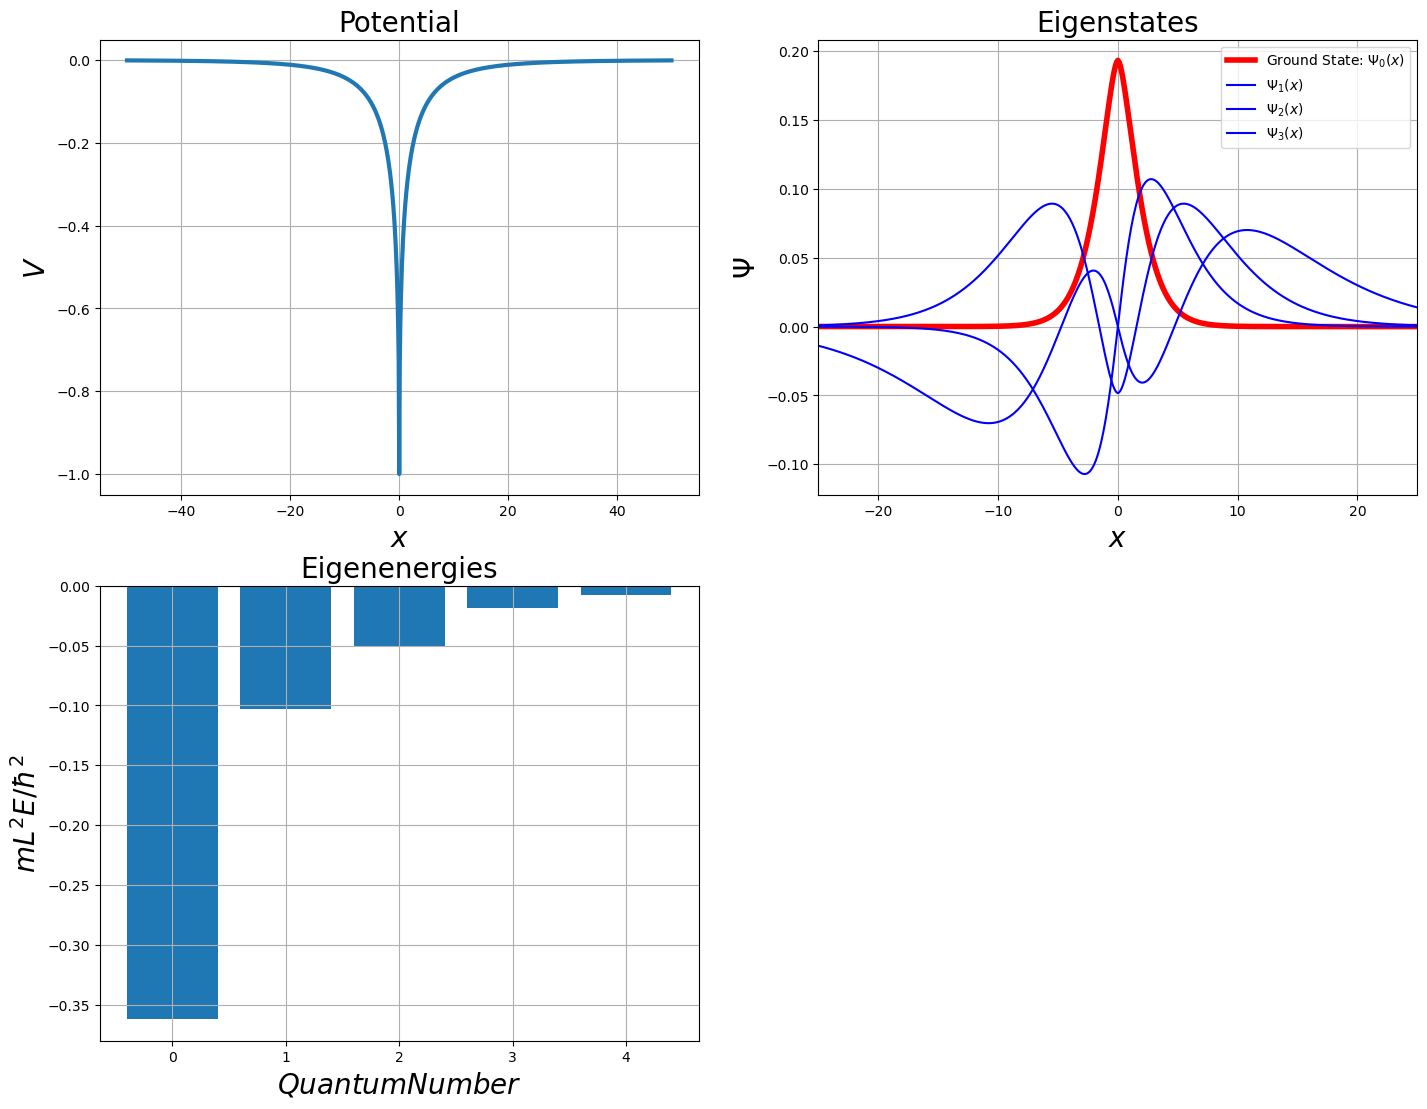

In [246]:
plt.figure(figsize=((17, 13)))

# Plot the potential function
plt.subplot(221)
plt.title('Potential', fontsize=20)
plt.plot(x, V(x), lw=3)
plt.ylabel('$V$', fontsize=20)
plt.xlabel('$x$', fontsize=20)
plt.grid()

# Plot the eigenstates
plt.subplot(222)
plt.plot(x[1:-1], psi.T[0], label=r'Ground State: $\Psi_0(x)$', linewidth=4.0, color='r')
plt.plot(x[1:-1], psi.T[1], label=r'$\Psi_1(x)$', color='b')
plt.plot(x[1:-1], psi.T[2], label=r'$\Psi_2(x)$', color='b')
plt.plot(x[1:-1], psi.T[3], label=r'$\Psi_3(x)$', color='b')
plt.legend(fontsize=10)
plt.title('Eigenstates', fontsize=20)
plt.ylabel('$\Psi$', fontsize=20)
plt.xlabel('$x$', fontsize=20)
plt.xlim([-25, 25])
plt.grid()

# Plot the first five eigenenergies
plt.subplot(223)
plt.title('Eigenenergies', fontsize=20)
plt.bar(np.arange(0, 5, 1), mE[0:5] / m)
plt.ylabel('$mL^2 E/\hbar^2$', fontsize=20)
plt.xlabel('$Quantum Number$', fontsize=20)
plt.grid()

plt.show()

Let's start by considering the boundary condition at $x = 50$ units (m if $\hbar$ has the correct units), which marks the boundary of the box, with $L$ being significantly large. Consequently, our functions attenuate well before reaching these boundaries, effectively simulating an infinite box within our simulation.

Moving on to determining the eigenenergy for the ground state with an accuracy of 1 part in 1000, we aim to assess how much the numerical result fluctuates as we modify the number of grid points. By comparing these values, we can estimate the margin of error.

It's essential to notice that the anticipated error for our numerical approach should scale as $(\Delta x)^2$. Considering that the scipy method for solving the eigenvalue problem maintains an error smaller than $1/1000$, we observe that the overall error in our result hinges on the accuracy of the second derivative approximation. From Taylor's expansion, we ascertain the approximation:

$$\frac{d^2f}{dx^2} \approx \frac{f(x+\Delta x)-2f(x)+f(x-\Delta x)}{(\Delta x)^2} - \frac{(\Delta x)^2}{12}\frac{d^4f}{dx^4}+\ldots$$

This implies that if we double the spacing ($\Delta x \rightarrow 2\Delta x$), the new error would proportionally increase to $\propto (2\Delta x)^2 = 4(\Delta x)^2$. The true value can be expressed as $E = E_1 + \epsilon_1 = E_2 + \epsilon_2$, where $E_1$ represents the numerical value for one grid resolution and its associated error $\epsilon_1$, and $E_2$ denotes the numerical value with doubled spacing. Substituting these values:

$$E_1 +\epsilon_1 = E_2 +\epsilon_2 \rightarrow E_1 +\epsilon_1 = E_2 +4\epsilon_1 \rightarrow \epsilon_1 \approx \frac{E_1-E_2}{3}$$

This approximation shows that the error $\epsilon_1$ is approximately one-third of the difference between $E_1$ and $E_2$.

In [247]:
# Set initial values
N = 7  # Initial number of grid points
err = 1  # Generic initial error value to start the loop
E0 = 0

# Loop until error is less than 0.001

while err > 0.001:
    # Increase grid points by a factor of 2, which is the same as decreasing the spacing by 2
    N = N*2
    # Now we do the same as we did before
    dx = 2*L/N  # Calculate grid spacing
    x = np.linspace(-L, L, N+1)
    
    d = (hbar**2)/(dx**2) + m*V(x)[1:-1]
    e = -(hbar**2)/(2*(dx**2)) * np.ones(len(d)-1)
    mE, psi = eigh_tridiagonal(d, e)
    # Calculate the difference between the ground state energies from different grid spacing
    err = abs(E0-mE[0]/m)/3
    # Update the calculated ground state energy
    E0 = mE[0]/m
    print(N, E0, err)

print('\nThe energy of the ground state with the requested precision is:', E0)

14 -0.9806063077035366 0.3268687692345122
28 -0.9252119426903072 0.01846478833774316
56 -0.7500080560039228 0.05840129556212811
112 -0.5039224715460779 0.08202852815261497
224 -0.40294667082797275 0.0336586002393684
448 -0.37269348916075984 0.010084393889070972
896 -0.3626511492073803 0.0033474466511265177
1792 -0.35913712567186784 0.0011713411785041483
3584 -0.3578878179876496 0.00041643589473940496

The energy of the ground state with the requested precision is: -0.3578878179876496


# Problem 3

Let's employ finite differences to solve the differential equation:

The equation used is: 
$$\frac{dT_i}{dt} = \kappa_i \frac{T_{i+1}-2T_i+T_{i-1}}{(\Delta x)^2}$$.

Then, expressing this as an explicit scheme:

$$\frac{T_i^{t+1}-T_i^{t}}{\Delta t} = \kappa_i \frac{T_{i+1}^{t+1}-2T_i^{t+1}+T_{i-1}^{t+1}}{(\Delta x)^2} \rightarrow T_i^{t+1}- \kappa_i \frac{\Delta t}{(\Delta x)^2}\left( T_{i+1}^{t+1}-2T_i^{t+1}+T_{i-1}^{t+1}\right) = T_i^{t} $$

To simplify computation, let's define $\alpha = \frac{\Delta t}{(\Delta x)^2}$, thus:

$$T_i^{t+1}- \kappa_i \alpha \left( T_{i+1}^{t+1}-2T_i^{t+1}+T_{i-1}^{t+1}\right) = T_i^{t} \rightarrow -\kappa_i\alpha T_{i-1}^{t+1} + (1+2\kappa_i\alpha)T_{i}^{t+1} - \kappa_i\alpha T_{i+1}^{t+1} = T_{i}^{t}$$

Now, incorporating boundary conditions, with two different conditions at each end:

$\textbf{a):}$ Keeping $T_N = 0$, implying $T_N^{t+1} = T_N^{t} = 0$. The update equation for the right-most grid points becomes:

$$-\kappa_{N}\alpha T_{N-1}^{t+1} + (1+2\kappa_{N}\alpha)T_{N}^{t+1} - \kappa_{N}\alpha T_{N} = T_{N}^{t}$$

Moving the boundary terms to the right-hand side:

$$-\kappa_{N}\alpha T_{N-1}^{t+1} + (1+2\kappa_{N}\alpha)T_{N}^{t+1} = T_{N}^{t} + \kappa_{N}\alpha T_{N}$$

This equation resembles:

$$\overline{\overline{A}} \vec{T}^{n+1} = \vec{T}^{n}+\alpha \kappa_{N} \vec{b}$$

For the insulated base of the slab, where $\left. \frac{dT}{dx} \right|_{x=0} = 0$ implies $T_0=T_1$. Hence, the update equation for $i=1$ is:

$$-\kappa_{1}\alpha T_{0}^{t+1} + (1+2\kappa_{1}\alpha)T_{1}^{t+1} - \kappa_{1}\alpha T_{2}^{t+1} = T_{1}^{t} \rightarrow (1+\kappa_{1}\alpha)T_{1}^{t+1}- \kappa_{1}\alpha T_{2}^{t+1} = T_{1}^{t}$$

Given the varying nature of the thermal diffusivity values across the bar, it's essential to incorporate their specific values for each grid point. We only have seven thermal diffusivity values throughout the bar. Simply utilizing these discrete values would result in a notably low-resolution estimation. To improve accuracy, we'll employ interpolation techniques to estimate the thermal diffusivity at positions where these values are not explicitly known.

In [248]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate

# We first import the data saved in the repository
file = np.loadtxt('final_data.txt', dtype = float)

# Then we retrive this data into two arrays
height = file[:,0]
diffusi = file[:,1]

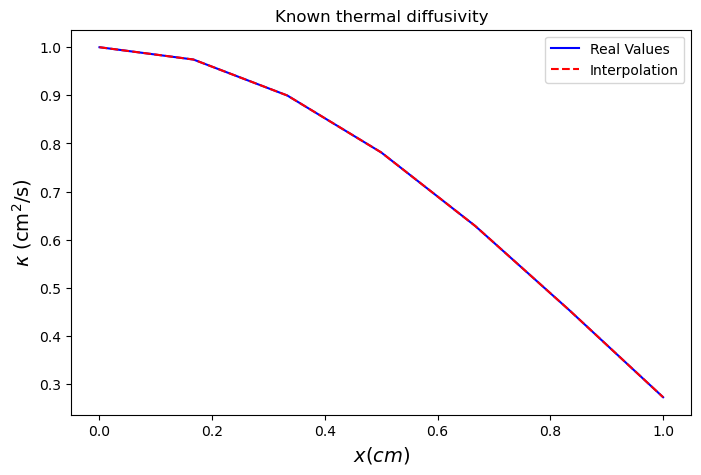

In [249]:
# Using the Scipy function interpolate we will interpolate the values for the thermal diffusivity

interpol_diffusi = scipy.interpolate.CubicSpline(height, diffusi)

# Let's plot the thermal diffusivity values just to check we did a good interpolation

plt.figure(figsize=(8,5))
plt.plot(height, diffusi, label = 'Real Values', color ='b')
plt.plot(height, interpol_diffusi(height), "--", label = 'Interpolation', color = 'r')
plt.title('Known thermal diffusivity')
plt.ylabel(r'$\kappa$ (cm$^2$/s)', fontsize = 14)
plt.xlabel(r'$x (cm)$', fontsize = 14)
plt.legend()
plt.show()

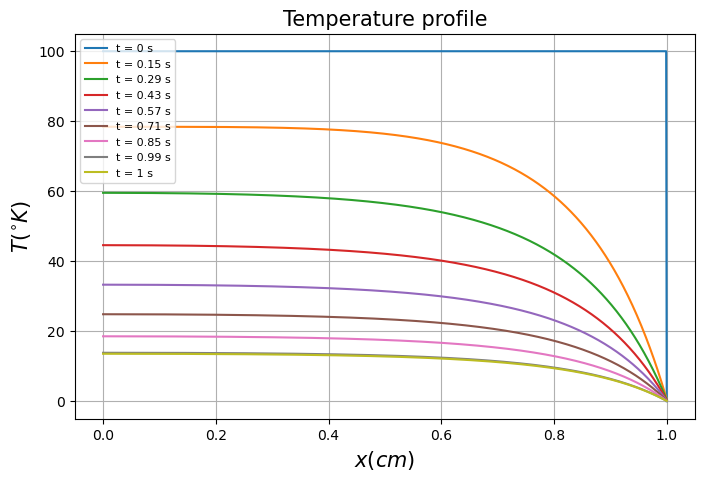

The temperature at the base of the slab at t = 1 second is: 13.5576 K


In [250]:
# Define the number of grid points
n = 1001

# Create an array of n points evenly spaced from 0 to 1. They will be the thickness points
x = np.linspace(0, 1, n)

# Set initial temperature condition
T = np.ones(n)
T[:] = 100
T[-1] = 0.0  # Set the last element of T array to 0 as boundary condition

# Define the number of time steps
nsteps = 100

# Calculate spatial step size and time step size
dx = x[1] - x[0]
dt = 1 / nsteps

# Calculate alpha
alpha = dt / dx**2

# Calculate coefficients for the tridiagonal matrix
b = 1 + 2 * alpha * np.ones(n) * interpol_diffusi(np.arange(n) * dx)
b[0] = 1 + alpha * interpol_diffusi(0 * dx)
a = -alpha * np.ones(n) * interpol_diffusi(np.arange(n) * dx)
c = -alpha * np.ones(n) * interpol_diffusi(np.arange(n) * dx)
c[-1] = 0.0
a[0] = 0.0

# Construct the tridiagonal matrix
AA = np.row_stack((a, b, c))

bvec = np.zeros(n)  # Create a zero vector
bvec[n-1] = 0 # Although the boundary condition is already set to zero, explicitly imposing it adds flexibility to our model

plt.figure(figsize=(8,5))
# Plot initial temperature profile
plt.plot(x, T, label='t = %lg s' % (0))
plt.title('Temperature profile')
plt.ylabel('$T (^{\circ}K)$', fontsize=15)
plt.xlabel('$x (cm)$', fontsize=15)

# Loop through time steps to solve the heat equation and plot results
for i in range(1, nsteps):
    # Solve the tridiagonal banded linear system for the temperature
    T = scipy.linalg.solve_banded((1, 1), AA, T + alpha * bvec)

    # Plot just q=7 temperature profiles
    if i % int(nsteps / 7) == 0:
        plt.plot(x, T, label='t = %lg s' % ((i + 1) * dt))
        plt.title('Temperature profile')
        plt.ylabel('$T$ ($^{\circ}$K)', fontsize=15)
        plt.xlabel('$x$ (cm)', fontsize=15)
        plt.grid()

# Plot the final temperature profile
plt.plot(x, T, label='t = %lg s' % (nsteps * dt))
plt.title('Temperature profile', fontsize=15)
plt.ylabel(r'$T (^{\circ}K)$', fontsize=15)
plt.xlabel(r'$x (cm)$', fontsize=15)
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Display the temperature at the base of the slab after the simulation
print('The temperature at the base of the slab at t = %lg second is: %lg K' % (nsteps * dt, T[0]))

## Problem 4

The rate at which each type of atom decreases over time is described by the following expression:

Let's seek an analytical solution for this equation. Starting with $\frac{dN}{dt} = -\frac{N}{\tau}$, we can integrate this equation:

$$\int_{N_0}^{N} \frac{dN}{N} = \int_{t_0}^{t} - \frac{1}{\tau}$$

Therefore, $\ln{\left (\frac{N}{N_0} \right)} = - \frac{t-t_0}{\tau} $, leading to the final solution:

$$N = N_0e^{-\frac{t-t_0}{\tau}}$$

Next, the total energy released per second due to radioactive decay is proportionate to:

$$\sum_i =\frac{dN_i}{dt} = \sum_i \frac{-N_i}{\tau_i}$$

First, let's create a plot of $\log_{10}(\tau)$ to verify whether $\tau$ is uniformly distributed within the range of $10^3$ to $10^6$.

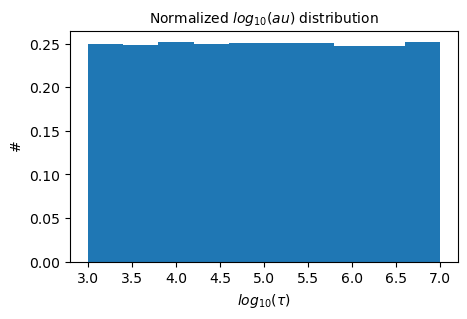

In [254]:
import numpy as np
import matplotlib.pyplot as plt

n = 100000
tau = 10**(np.random.uniform(3, 7, n))

plt.figure(figsize=(5,3))
plt.hist(np.log10(tau), density=True)
plt.title('Normalized $log_{10}(\tau)$ distribution', fontsize=10)
plt.xlabel(r'$log_{10}(\tau)$', fontsize=10)
plt.ylabel(r'$\#$', fontsize=10)
plt.show()

Following that check, let's perform the decay integration for a set of $100$ distinct $\tau$ values.

In [252]:
# Define the number of tau samples, 100 as the heading asks
n = 100

# Generate random values of tau distributed uniformly in log scale
tau = 10**(np.random.uniform(3, 7, n))

# Initialize a list with zeros and set values where it equals zero to 10^13
N_list = np.zeros(n)
N_list[N_list == 0] = 10**13 # We take a large number of atoms 

# Create an array of times exponentially distributed in log space
T = 10**np.linspace(0, 6, 1000)
T[0] = 0  # Set the first element to 0
I = np.zeros(len(T)-1)  # Initialize an array for storing energy values

# Calculate the initial rate of change of energy
dI = sum(-N_list/tau)
I[0] = abs(dI)

# Loop through time steps and update energy values
for i in range(1, len(T)-1):
    dI = sum(-N_list/tau)
    # We take the absolute value since we want to check the behaviour, and seeing a positive decrease is easier to visualize
    # However the beaviour and comprovations would be the same, since the factor I[0] would be negative
    I[i] = abs(dI) 
    # Update N_list based on exponential decay with time difference
    N_list = N_list * np.exp(-(abs(T[i] - T[i+1])) / tau)


After performing the integration, our goal is to examine whether the total energy per second ($I$) follows a power-law decay, $\propto \frac{1}{t}$. To evaluate this, we assume that the energy released per second conforms to this behavior and proceed to logarithmically transform the equation.

$$I(t) = \frac{C}{t} \rightarrow \ln{(I(t))} = -\ln{(t)} + \ln{(C)} $$

Where $C$ represents the proportional constant. A linear decrease of $I$ in the log-log plane would confirm the Li & Paczynski's prediction.

Additionally, I'll plot a comparison function to contrast $I$. This fuction will be $\frac{I_0}{t}$ with an actual $\propto \frac{1}{t}$ decaying function, scaled to match the order of magnitude of our results.

This results in the two following plots. The first illustrates our total energy released per second compared to the model function. Here, despite differing scales and a faster decreasing for the model function, they exhibit similar behavior. However, when we shift to the log-log plane, we observe that the total energy per second remains nearly constant initially but begins a linear decay, precisely in line with our model. This can be explained with this difference in the decreasing times at the beginning. Therefore, we conclude that Li & Paczynski's prediction was accurate beyond a certain time frame, approximately around $1000$ seconds.

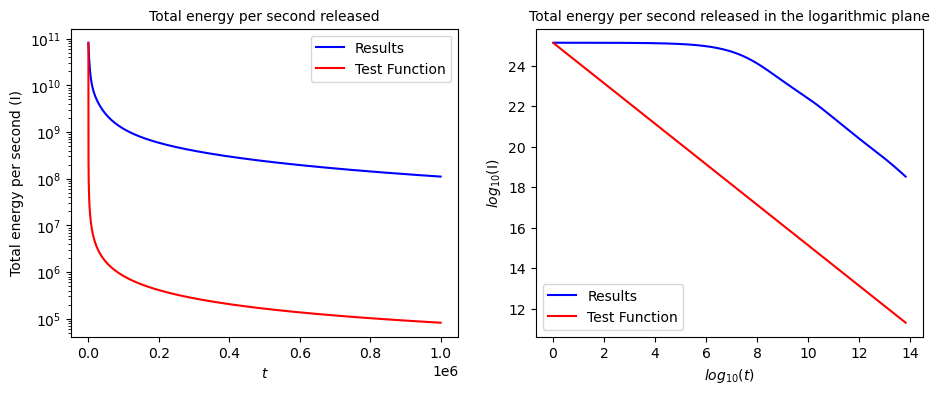

In [253]:
plt.figure(figsize=((11,4)))

# Plot total energy per second released versus time
plt.subplot(121)
plt.title('Total energy per second released', fontsize=10)
plt.plot(T[1:], I, label = 'Results',color = 'b')
plt.plot(T[1:], I[0]/T[1:], label = 'Test Function', color = 'r')
plt.legend()
plt.yscale('log')
plt.ylabel(r'Total energy per second (I)', fontsize=10)
plt.xlabel(r'$t$', fontsize=10)

# Plot total energy per second released in the logarithmic plane
plt.subplot(122)
plt.title('Total energy per second released in the logarithmic plane', fontsize=10)
plt.plot(np.log(T[1:]), np.log(I), label = 'Results', color = 'b')
plt.plot(np.log(T[1:]), np.log(I[0]/T[1:]),label = 'Test Function', color = 'r')
plt.legend()
plt.ylabel(r'$log_{10}$(I)', fontsize=10)
plt.xlabel(r'$log_{10}(t)$', fontsize=10)
plt.show()

We could have approached this problem analytically, solving $\frac{dN}{dt} = -\frac{N}{\tau}$, as demonstrated earlier, or numerically, as shown by the following equations:

$$\frac{N_{i+1}-N_i}{\Delta t} = -\frac{N_i}{\tau}$$

This numerical approach leads to:

$$N_{i+1} = -\frac{\Delta t}{\tau} N_i+N_i = (1-\frac{\Delta t}{\tau})N_i$$

This procedure is similar to performing a Taylor expansion for the analytic solution.